# Exploratory data analysis 

## Imports

In [9]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

## Prepare dataframe

In [10]:
DATA_DIR = pathlib.Path('../Coding Challenge - Data(20221128)')
fprop = fm.FontProperties(fname = './resources/NotoSansJP-Thin.otf')

stores_df = pd.read_csv(DATA_DIR / 'stores.csv')
transactions_df = pd.read_csv(DATA_DIR / 'transactions.csv')
users_df = pd.read_csv(DATA_DIR / 'users.csv')
dataframe = transactions_df.merge(users_df, left_on='user_id', right_on='id', how='left').merge(
    stores_df, left_on='store_id', right_on='id', how='left').drop(columns=['id_x','id_y','id','user_id','store_id'])

# Drop columns that are not used in this analysis
dataframe = dataframe.drop(columns=['lat','lon'])

# Convert date columns to datetime
dataframe['event_occurrence'] = pd.to_datetime(dataframe['event_occurrence'])
# Convert categorical columns to category
category_columns = ['gender', 'category', 'nam', 'laa']
for column in category_columns:
    dataframe[column] = dataframe[column].astype('category')

# Drop rows with missing values
dataframe = dataframe.dropna()

dataframe.head()

,event_occurrence,amount,gender,age,nam,laa,category
0,2020-01-01 06:40:43.323987,315,M,88.0,Saitama Ken,Soka Shi,コンビニ
1,2020-01-01 07:04:25.968615,1646,M,44.0,Gunma Ken,Meiwa Cho,ショッピング
2,2020-01-01 07:06:16.164563,385,M,16.0,Hiroshima Ken,Fukuyama Shi,コンビニ
3,2020-01-01 07:07:26.029685,166,F,79.0,Tokyo To,Nerima Ku,グルメ
4,2020-01-01 07:12:24.448015,656,F,79.0,Tokyo To,Edogawa Ku,スーパーマーケット


## Raw data visualization

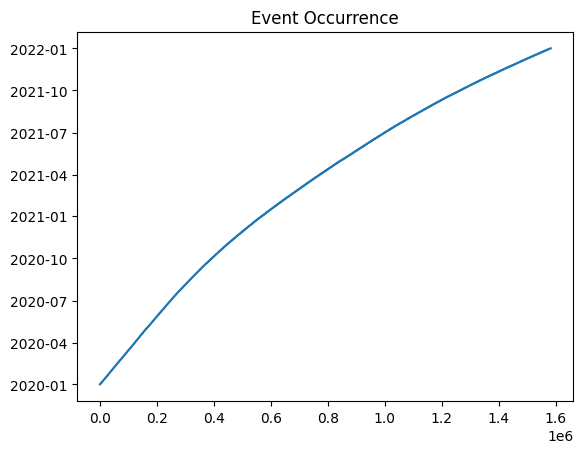

Min date : 2020-01-01 06:40:43.323987  Max date : 2021-12-31 17:09:49.237044


In [11]:
# visualize date-time data
plt.plot(dataframe['event_occurrence'])
plt.title('Event Occurrence')
plt.show()
print(
    f"Min date : {dataframe['event_occurrence'].min()}  Max date : {dataframe['event_occurrence'].max()}")


Data available between 2020-01 and 2021-12, without big gaps.

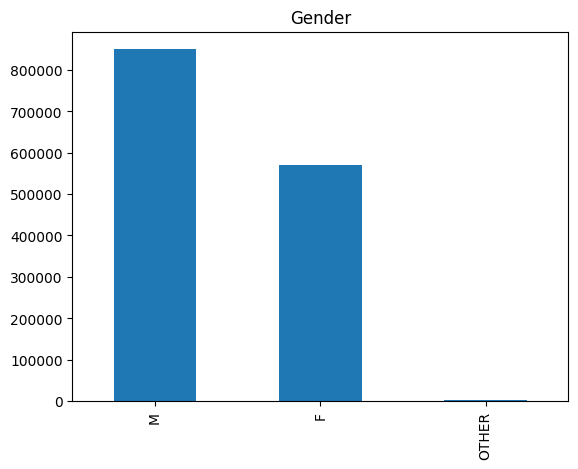

In [12]:
dataframe['gender'].value_counts().plot(kind='bar')
plt.title("Gender")
plt.show()

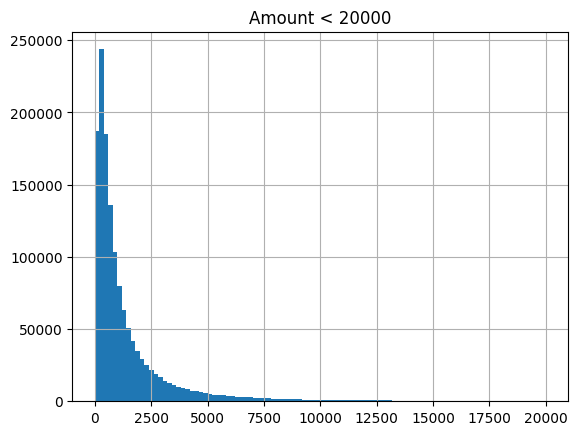

Number of amounts above 20000: 6  Max amount 1883119


count    1.421978e+06
mean     1.704403e+03
std      5.400297e+03
min      2.000000e+00
25%      3.320000e+02
50%      7.330000e+02
75%      1.675000e+03
max      1.883119e+06
Name: amount, dtype: float64

In [13]:
dataframe['amount'].hist(range=(0, 20000), bins=100)
plt.title("Amount < 20000")
plt.show()
print(
    f"Number of amounts above 20000: {len(dataframe[dataframe['amount'] > 1000000])}  Max amount {dataframe[dataframe['amount'] > 1000000]['amount'].max()}")
dataframe['amount'].describe()


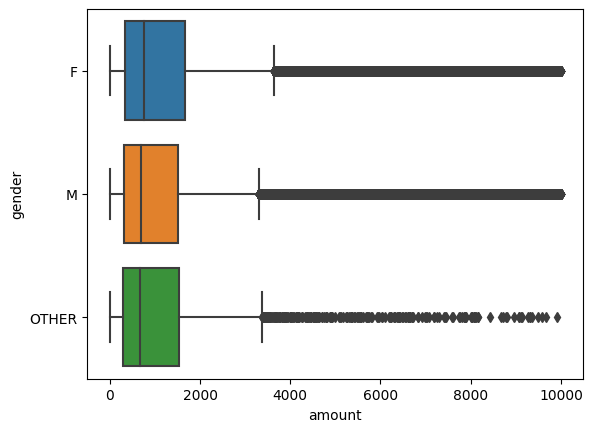

In [24]:
sns.boxplot(data=dataframe[dataframe['amount'] < 10000], x='amount', y='gender');


Upper fence: 3689.5


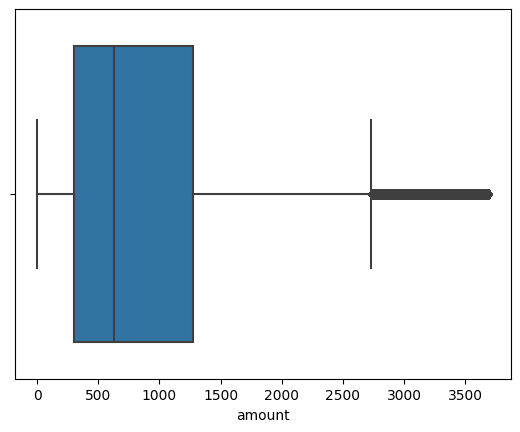

In [23]:
quantiles = dataframe['amount'].quantile([.25, .75])
iqr = quantiles[0.75]-quantiles[0.25]
upper_fence = quantiles[0.75] + 1.5 * iqr
print(f"Upper fence: {upper_fence}")
sns.boxplot(data=dataframe[dataframe['amount'] < upper_fence], x='amount');


Values of the 'amount' is highly skewed, the upper fence values is 3689.5, all values above this value are outliers.

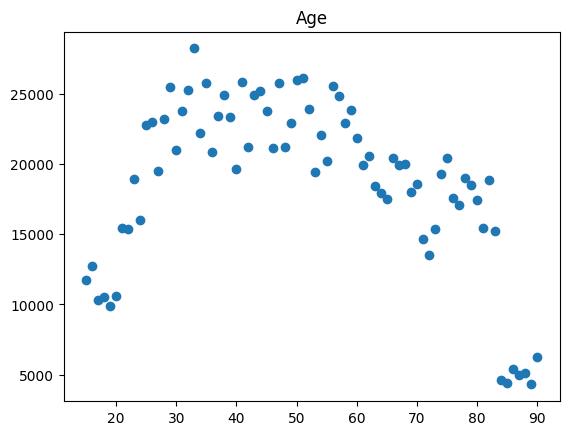

In [16]:
age_counts = dataframe['age'].value_counts()
plt.scatter(age_counts.index, age_counts.values)
plt.title("Age")
plt.show()

The 'age' column has some sudden changes at the both ends, but otherwise it looks clean.

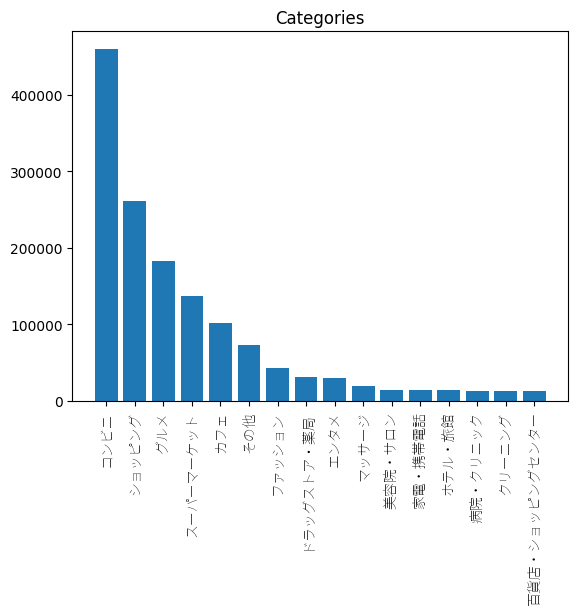

In [17]:
counts = dataframe['category'].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Categories')
plt.xticks(rotation=90, fontproperties=fprop)
plt.show()

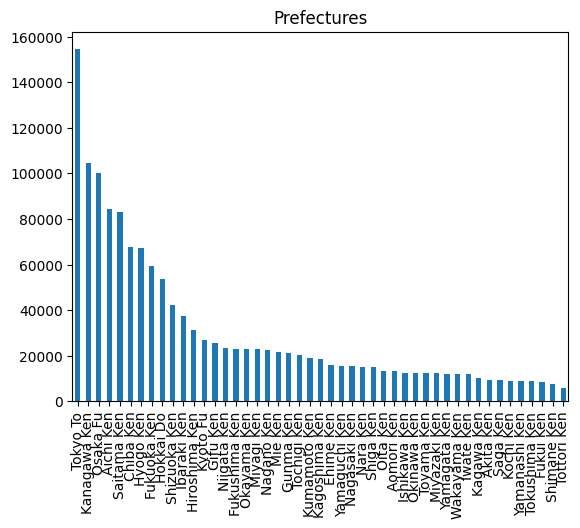

In [18]:
dataframe['nam'].value_counts().plot(kind='bar')
plt.title('Prefectures')
plt.show()


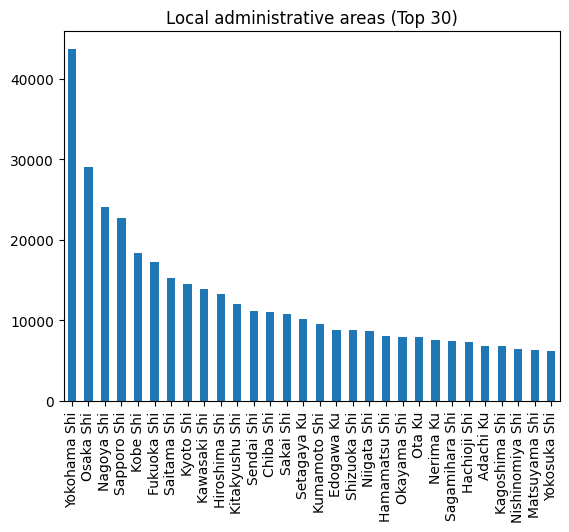

In [19]:
# Plot LAA, only show top 30
dataframe['laa'].value_counts().head(30).plot(kind='bar')
plt.title('Local administrative areas (Top 30)')
plt.show()

## Basic relationships

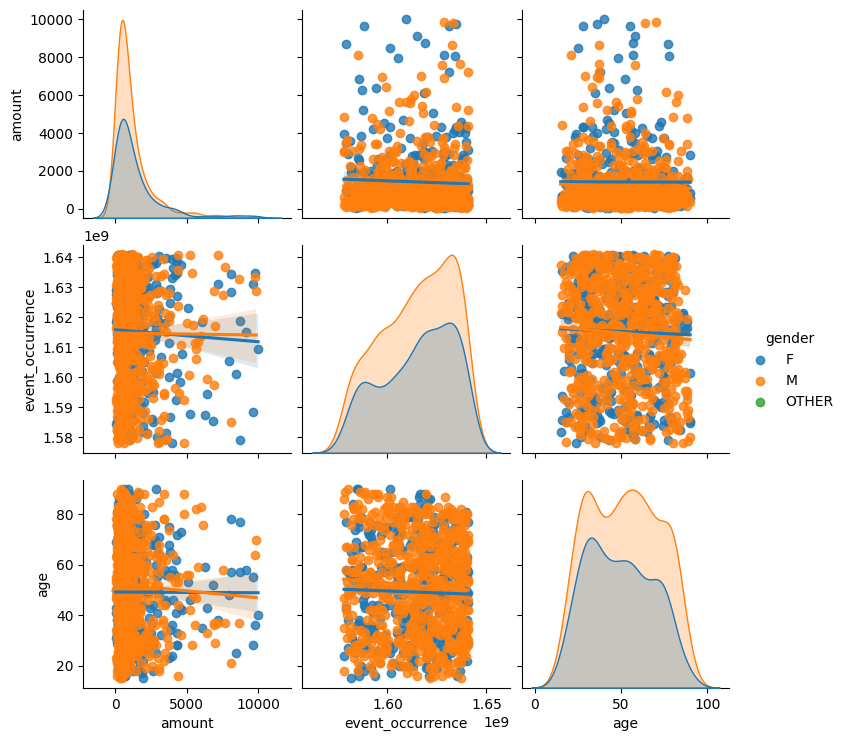

In [22]:
visualization_dataset = dataframe[(dataframe['amount'] < 10000) & (dataframe['gender'] != 'OTHER')].sample(1000)
# Convert datetime to integer
visualization_dataset['event_occurrence'] = visualization_dataset['event_occurrence'].astype('int64') / 10**9
sns.pairplot(visualization_dataset, vars=['amount', 'event_occurrence', 'age'], kind='reg', hue="gender");


It seems that there are correlations between 'age' and 'amount', and 'event_occurence' and 'amount'. The 'amount' slightly increases with the 'event_occurence' and with the 'age'.

## Seasonality

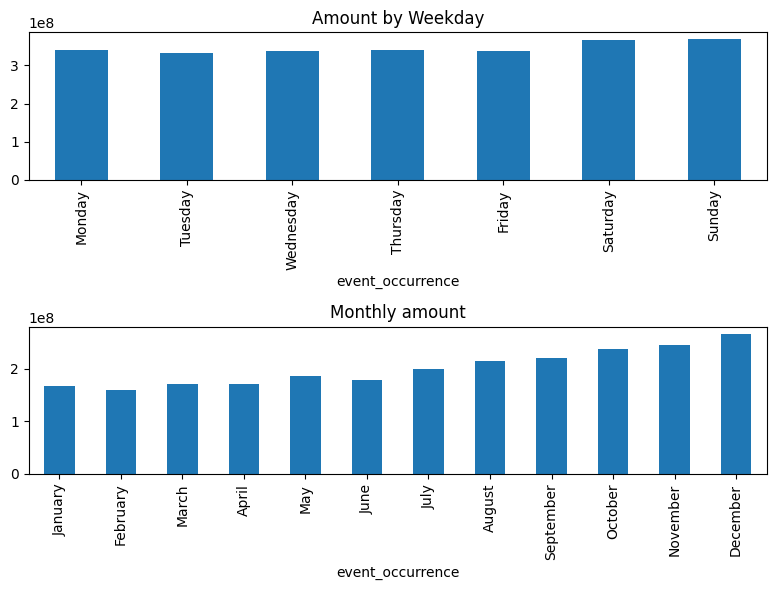

In [21]:
trends_df = dataframe.set_index('event_occurrence')
weekday_order = ['Monday', 'Tuesday', 'Wednesday',
                 'Thursday', 'Friday', 'Saturday', 'Sunday']
by_weekday = trends_df.groupby(trends_df.index.day_name())[
    'amount'].sum().loc[weekday_order]


# group by month and sum the amounts
by_month = trends_df.groupby(trends_df.index.month_name())['amount'].sum()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
by_month = by_month.loc[month_order]


# plot the results
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
by_weekday.plot(kind='bar', ax=axes[0], title='Amount by Weekday')
by_month.plot(kind='bar', ax=axes[1], title='Monthly amount')
plt.tight_layout()
plt.show()


Amounts are almost the same for all weekdays, only a small increase on weekend. On the other hand, monthly amounts are increasing from January to December. There is a big decrease in January after December, this should be taken into account when making predictions.